## Introduction


In this lab, you will build and train a CNN model to classify electronic symbols. The dataset available was created a long time ago (2015), back then this problem was sort out using classic ANN, but it was necessary to extract some features like rotation angle, rescale image, using OpènCV in order to achieve a better performance.
<br> This time the idea is create a CNN model that could automatically extract features from the dataset to make it not sensible of noise in the image like symbol rotation, rescale or offset. 

## Import Libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if(gpus):
    try:
        for gpu in gpus:            
            tf.config.experimental.set_memory_growth(gpu,True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
         # Visible devices must be set before GPUs have been initialized
        print(e)
gpus

1 Physical GPUs, 1 Logical GPUs


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset

The dataset consist in three types of pasive electronic symbol component, "capacitor", "inductor" and "resistance". The original image of each one is "R1.png", "C1.png" and "L1.png".

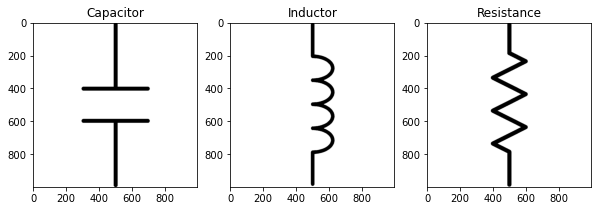

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10)) # define your figure and axes

capactor_symbol = plt.imread('C1.png')
axs[0].imshow(capactor_symbol)
axs[0].title.set_text('Capacitor')

inductor_symbol = plt.imread('L1.png')
axs[1].imshow(inductor_symbol)
axs[1].title.set_text('Inductor')

resistance_symbol = plt.imread('R1.png')
axs[2].imshow(resistance_symbol)
axs[2].title.set_text('Resistance')

Based on them was created a dataset of 9000 symbols of each class using python sccript "dataset_creator.py". This script create new symbols based on data augmentation applying rotation and offset. For example:

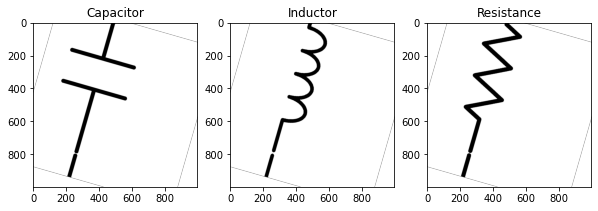

In [4]:
path = './dataset/train/'
capacitor_symbol_sample = os.listdir(path + '/capacitor')[0]
inductor_symbol_sample = os.listdir(path + '/inductor')[0]
resistance_symbol_sample = os.listdir(path + 'resistance')[0]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10)) # define your figure and axes

capactor_symbol = plt.imread(path + 'capacitor/' + capacitor_symbol_sample)
axs[0].imshow(capactor_symbol)
axs[0].title.set_text('Capacitor')

inductor_symbol = plt.imread(path + 'inductor/' + inductor_symbol_sample)
axs[1].imshow(inductor_symbol)
axs[1].title.set_text('Inductor')

resistance_symbol = plt.imread(path + 'resistance/' + resistance_symbol_sample)
axs[2].imshow(resistance_symbol)
axs[2].title.set_text('Resistance')

<a id="item42"></a>

# Construct ImageDataGenerator Instances

In this part, we will create ImageDataGenerator for the training set and another one for the validation set. Our model will be compared with VGG16 that was originally trained on 224 × 224 images, so we have to scale the image to 224x224 and normalize between [0,1]

In [5]:
# Define Global Constants
num_classes = 3
image_resize = 224
batch_size_training = 20
batch_size_test = 20

In [6]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [7]:
train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 21600 images belonging to 3 classes.


In [8]:
validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 5400 images belonging to 3 classes.


## Create CNN Model

In this part we are going to create a Keras CNN model from scratch. The idea is to add many CONV+POOL layers to reduce de image size and reduce the weights to be train in the fully connected layers.

### Build and fit model

In [ ]:
# How the output shape of each layer is calculated (For reference only):
# Z = ( (N+2*p)-f+1)/S
# N: inputer shape of that layer
# f: size of kernel filter
# s: strides
# p: padding

In [48]:
my_model = Sequential()

kernel = (5,5)
filters = 8

# CONV + POOL layers
my_model.add(Conv2D(filters, kernel, strides=(1, 1), padding='same', activation='relu', input_shape=(224,224,3)))
my_model.add(MaxPooling2D((2,2), strides=(2,2)))

for i in range(1,4):
    my_model.add(Conv2D( (2**i)* filters, kernel, strides=(1, 1), padding='same', activation='relu'))
    my_model.add(MaxPooling2D((2,2), strides=(2,2)))

# Fully Connected layers
my_model.add(Flatten())
my_model.add(Dense(64, activation='relu'))
my_model.add(Dropout(0.2))

my_model.add(Dense(64, activation='relu'))
my_model.add(Dropout(0.2))

# Layer 6: Outputlayer
my_model.add(Dense(num_classes, activation='softmax'))

my_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 224, 224, 8)       608       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 16)      3216      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 56, 56, 32)        12832     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 64)      

In [49]:
# Compile model using the adam optimizer.
my_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 1

In [51]:
fit_history = my_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Epoch 1/1
1080/1080 [==============================] - 580s 537ms/step - loss: 0.5627 - accuracy: 0.8022 - val_loss: 1.8811e-04 - val_accuracy: 1.0000


In [58]:
my_model.save('classifier_my_model.h5')

In [23]:
# Load the model
my_model = load_model('classifier_my_model.h5')

# Build, Compile and Fit VGG16 Model

In [52]:
train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 21600 images belonging to 3 classes.


In [9]:
validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 5400 images belonging to 3 classes.


In [27]:
vgg16_model = Sequential()

In [28]:
# in order to leave out the output layer of the pre-trained model, we will use the argument include_top and set it to False.
vgg16_model.add(VGG16(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

In [29]:
# Define our output layer as a Dense layer, that consists of two nodes and uses the Softmax function as the activation function.
vgg16_model.add(Dense(num_classes, activation='softmax'))
vgg16_model.layers[0].trainable = False
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 1,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
# Compile model using the adam optimizer.
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

In [32]:
fit_history = vgg16_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

Epoch 1/2
1080/1080 [==============================] - 558s 516ms/step - loss: 0.0259 - accuracy: 0.9937 - val_loss: 5.1982e-05 - val_accuracy: 1.0000
Epoch 2/2
1080/1080 [==============================] - 560s 518ms/step - loss: 1.8115e-04 - accuracy: 1.0000 - val_loss: 2.3787e-05 - val_accuracy: 1.0000


In [40]:
# Then I save the model at colab and download it to continue working at jupyter
vgg16_model.save('classifier_vgg16_model.h5')

In [35]:
# Load the model
vgg16_model = load_model('classifier_vgg16_model.h5')

C:\Python37\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


<a id="item43"></a>

## Test and compare models

Create ImageDataGenerator for test

In [53]:
evaluate_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 12 images belonging to 3 classes.


In [54]:
vgg16_evaluate_history = vgg16_model.evaluate_generator(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 0s 444ms/step


In [55]:
# VGG16 performance
print("VGG16 Accuracy:", vgg16_evaluate_history[1])

VGG16 Accuracy: 1.0


In [56]:
my_evaluate_history = my_model.evaluate_generator(
    evaluate_generator,
    verbose=1,
)

1/1 [==============================] - 0s 209ms/step


In [57]:
# My model performance
print("My model Accuracy:", my_evaluate_history[1])

My model Accuracy: 0.75


# Results

The results are the expected, the VGG16 has better accuracy and performance. Because the VGG16 is a pre-trained model.
<br> Our model is trained with few images, we need a bigger dataset with more differents images to extract features.
<br> We will continue using de VGG16 in the follow section.

## Show predict results on

In this part, we will create a predict_generator to test and show the test dataset. This test has the worse and difficult images to classify.
<br> System will save results in a list associated to each class.

<center>
    <ul style="list-style-type:none">
        <li>Capacitor</li>  
        <li>Inductor</li> 
        <li>Resistance</li>
        <li>...</li>
    </ul>
</center>

In [25]:
vgg16_predict = vgg16_model.predict_generator(
    evaluate_generator
)
vgg16_predict

array([[1.0000000e+00, 6.5516542e-10, 1.0191002e-09],
       [1.0000000e+00, 7.5523893e-11, 9.9649532e-11],
       [9.9999964e-01, 1.9533883e-10, 3.1325740e-07],
       [9.9772710e-01, 2.2804049e-04, 2.0449355e-03],
       [5.2920357e-10, 9.9999976e-01, 2.4457503e-07],
       [9.4578720e-11, 9.9993718e-01, 6.2762963e-05],
       [7.4264422e-06, 9.9997163e-01, 2.1004544e-05],
       [6.5416725e-06, 9.7943407e-01, 2.0559354e-02],
       [4.5594124e-06, 2.0159774e-08, 9.9999547e-01],
       [4.0135201e-05, 3.3530692e-09, 9.9995983e-01],
       [6.1475910e-02, 1.5129245e-02, 9.2339480e-01],
       [1.9764809e-04, 9.3403304e-07, 9.9980146e-01]], dtype=float32)

In [26]:
# Print list
result_index = ['Capacitor' if (s == 0) else 'Inductor' if (s == 1) else 'Resistance' for s in np.argmax(vgg16_predict,axis=1)]
result_index

['Capacitor',
 'Capacitor',
 'Capacitor',
 'Capacitor',
 'Inductor',
 'Inductor',
 'Inductor',
 'Inductor',
 'Resistance',
 'Resistance',
 'Resistance',
 'Resistance']

The data_generator used transform the images [0 255] vales to [-1 1], imshow not support values from -1 to 1, so we need to make a new data generator to show the testset

In [23]:
my_data_generator = ImageDataGenerator(
    rescale=1./255
)

test_generator = my_data_generator.flow_from_directory(
    'dataset/test',
    target_size=(image_resize, image_resize),
    shuffle=False)

Found 12 images belonging to 3 classes.


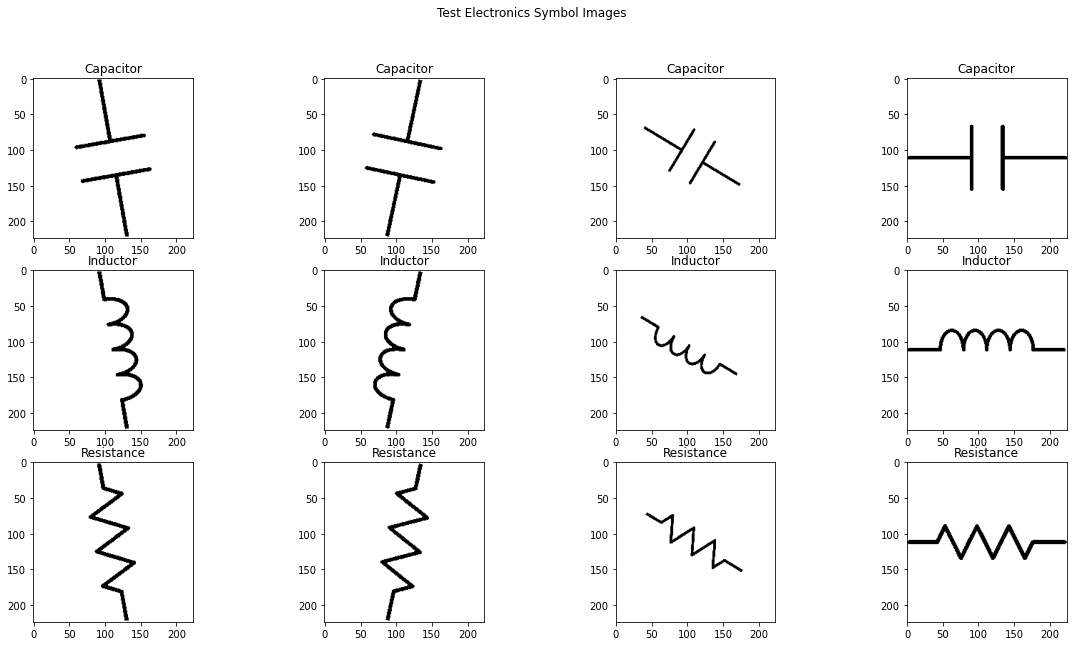

In [27]:


batch = test_generator.next()
batch_images = test_generator.next()[0]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) # define your figure and axes
ind = 0
for ax1 in axs:
    for ax2 in ax1:
        image_data = batch_images[ind]
        ax2.imshow(image_data)
        ax2.title.set_text(result_index[ind])
        ind += 1

fig.suptitle('Test Electronics Symbol Images') 
plt.show()
